In [12]:
!pip install validclust

## Importing Libraries

In [13]:
import tensorflow_datasets as tfds
import cv2
import numpy as np
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm, trange
from sklearn.metrics import  pairwise_distances, silhouette_samples, silhouette_score
import matplotlib.cm as cm
from validclust.indices import dunn

np.random.seed(10)

## Obtaining the dataset through TFDS

In [14]:
x_train, y_train = tfds.as_numpy(tfds.load(
    'cifar10',
    split='train',
    batch_size=-1,
    as_supervised=True,
))

In [15]:
x_test, y_test = tfds.as_numpy(tfds.load(
    'cifar10',
    split='test',
    batch_size=-1,
    as_supervised=True,
))

## Defining utility functions

In [16]:
def get_metrics(data, labels):
    #if data has more than 2 dimensions
    if(len(data.shape)>2):  
      data = data.reshape((data.shape[0], -1))
    score = silhouette_score(data, labels)
    dist = pairwise_distances(data)
    di = dunn(dist, labels)
    print('Average Silhoutte Coefficient: ' + str(score))
    print('Dunn Index: ' + str(di))

In [17]:
def plot_silhoutte_analysis(data, labels, n_clusters):
    if(len(data.shape)>2):  
      data = data.reshape((data.shape[0], -1))

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 10)

    ax1.set_xbound(lower = -0.2, upper = 0.35)

    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])
    
    silhouette_avg = silhouette_score(data, labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(data, labels)

    y_lower = 10
    for i in range(n_clusters):
      ith_cluster_silhouette_values = \
          sample_silhouette_values[labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3])

    plt.show()

# K-Means Clustering

## Implementing K-Means Clustering

In [18]:
class KMeansClusterer:
  def __init__(self, num_clusters):
    self.num_clusters = num_clusters
    self.centroids = []

  def fit(self, data, num_iterations, seed = 10):

    #if data has more than 2 dimensions
    if(len(data.shape)>2):  
      data = data.reshape((data.shape[0], -1))
    
    #Step 1: Initialize Random Centroids from the Dataset
    np.random.seed(seed)
    idx = np.random.choice(len(data), self.num_clusters, replace=False)
    self.centroids = data[idx, :]   

    #Step 2: Find distances from each centroid and classify each datapoint based on the distnances    
    labels = self.predict(data)

    #Step 4: Repeat the steps 
    t = trange(num_iterations)

    count = 1

    for _ in t:
      prev_score = silhouette_score(data, labels)
      
      self.centroids = []

      for i in range(self.num_clusters):
        temp_cent = data[labels==i].mean(axis=0)  #Recalculating center based on the clusters
        self.centroids.append(temp_cent)

      # print(self.centroids)  
      
      self.centroids = np.vstack(self.centroids)  #Updating the centroids

      labels = self.predict(data) #Recalculating labels

      # data = data.reshape((data.shape[0], -1))
      score = silhouette_score(data, labels)

      if(np.abs(prev_score-score)<0.00001):       #If no change, convergence achieved thus break out of loop
        break
   
    return labels

  def get_metrics(self, data, labels):
    #if data has more than 2 dimensions
    if(len(data.shape)>2):  
      data = data.reshape((data.shape[0], -1))
    score = silhouette_score(data, labels)
    dist = pairwise_distances(data)
    di = dunn(dist, labels)
    print('Average Silhoutte Coefficient: ' + str(score))
    print('Dunn Index: ' + str(di))

  def get_distance(self, data):
    #if data has more than 2 dimensions
    if(len(data.shape)>2):  
      data = data.reshape((data.shape[0], -1))
    return cdist(data, self.centroids ,'euclidean')

  def predict(self, data):
    if(len(data.shape)>2):  
      data = data.reshape((data.shape[0], -1))
    distances = cdist(data, self.centroids ,'euclidean')
    labels = np.array([np.argmin(i) for i in distances])
    return labels

  def plot_silhoutte_analysis(self, data):
    if(len(data.shape)>2):  
      data = data.reshape((data.shape[0], -1))

    labels = self.predict(data)

    n_clusters = self.num_clusters

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 10)

    ax1.set_xbound(lower = -0.2, upper = 0.35)

    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])
    
    silhouette_avg = silhouette_score(data, labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(data, labels)

    y_lower = 10
    for i in range(n_clusters):
      ith_cluster_silhouette_values = \
          sample_silhouette_values[labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3])

    plt.show()

## K-Means on CIFAR10 test dataset

### Preparing the dataset

Converting from RGB to grayscale and scaling the pixel intensity values to [0,1]

In [19]:
x_test = np.array([cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) for x in x_test], dtype = np.uint8)/255

### Training the K-means clustering model

In [20]:
data = x_test

In [21]:
cifar_clusters = KMeansClusterer(10)

In [22]:
for i in [100, 300, 500, 1000]:
  print('For '+str(i)+' iterations:\n')
  labels = cifar_clusters.fit(data = data, num_iterations = i, seed = 10)
  cifar_clusters.get_metrics(data, labels)
  print('\n')

For 100 iterations:



 25%|██▌       | 25/100 [04:10<12:32, 10.03s/it]


Average Silhoutte Coefficient: 0.056582107209604965
Dunn Index: 0.09276830030490865


For 300 iterations:



  8%|▊         | 25/300 [04:16<46:56, 10.24s/it]


Average Silhoutte Coefficient: 0.056582107209604965
Dunn Index: 0.09276830030490865


For 500 iterations:



  5%|▌         | 25/500 [04:11<1:19:43, 10.07s/it]


Average Silhoutte Coefficient: 0.056582107209604965
Dunn Index: 0.09276830030490865


For 1000 iterations:



  2%|▎         | 25/1000 [04:12<2:43:52, 10.08s/it]


Average Silhoutte Coefficient: 0.056582107209604965
Dunn Index: 0.09276830030490865




### Plotting clusters

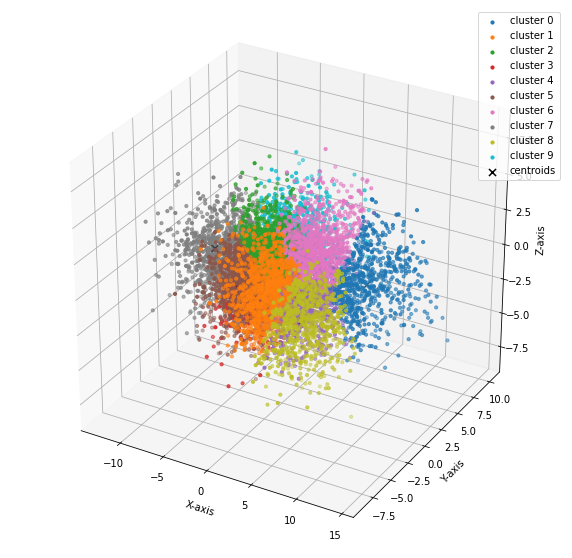

In [23]:
from sklearn.decomposition import PCA

u_labels = np.unique(labels)

pca = PCA(n_components=3)
data_d = pca.fit_transform(data.reshape((data.shape[0], -1)))
cent = pca.fit_transform(cifar_clusters.centroids)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

for i in u_labels:
    ax.scatter(data_d[labels == i , 0], data_d[labels == i , 1], data_d[labels == i , 2], label = 'cluster '+str(i), marker= 'o', s = 10)

ax.scatter(cent[ : , 0], cent[: , 1], cent[: , 2], label = 'centroids', marker='x', c = 'black', s = 50)

plt.legend(scatterpoints = 1)

plt.show()

### Silhoutte Analysis

For n_clusters = 10 The average silhouette_score is : 0.056582107209604965


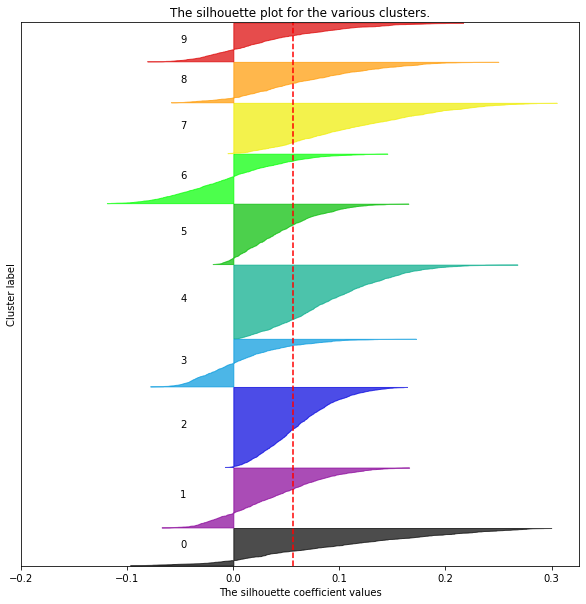

In [24]:
cifar_clusters.plot_silhoutte_analysis(data)

# Autoencoders

## Importing Libraries

In [25]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Input, Activation, Flatten, Reshape
from tensorflow.keras import Model
from sklearn.cluster import KMeans
tf.random.set_seed(0)

In [26]:
x_train = np.expand_dims(np.array([cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) for x in x_train], dtype = np.uint8)/255, axis = -1)  

In [36]:
x_train.shape

(50000, 32, 32, 1)

## AutoEncoder Architecture

In [37]:
def autoencoder(input_shape = (32,32,1)):
  X_input = Input(shape=input_shape, name = 'input')

  X = Conv2D(64, (3,3), padding='same', name = 'enc_conv1')(X_input)
  X = BatchNormalization(name = 'enc_bn1')(X)
  X = Activation('relu', name = 'enc_act1')(X)
  X = MaxPooling2D((2,2), padding = 'same', name = 'enc_mp1')(X)
  X = Conv2D(32, (3,3), padding='same', name = 'enc_conv2')(X)
  X = BatchNormalization(name = 'enc_bn2')(X)
  X = Activation('relu', name = 'enc_act2')(X)
  X = MaxPooling2D((2,2), padding = 'same', name = 'enc_mp2')(X)
  X = Conv2D(16, (3,3), padding='same', name = 'enc_conv3')(X)
  X = BatchNormalization(name = 'enc_bn3')(X)
  X = Activation('relu', name = 'enc_act3')(X)
  encoding = Flatten(name = 'encoding')(X)

  X = Reshape((8,8,16), name = 'encoding_reshape')(encoding)
  X = Conv2D(16, (3,3), padding='same', name = 'dec_conv1')(X)
  X = BatchNormalization(name = 'dec_bn1')(X)
  X = Activation('relu', name = 'dec_act1')(X)
  X = UpSampling2D((2,2), name ='dec_us1')(X)
  X = Conv2D(32, (3,3), padding='same', name = 'dec_conv2')(X)
  X = BatchNormalization(name = 'dec_bn2')(X)
  X = Activation('relu', name = 'dec_act2')(X)
  X = UpSampling2D((2,2), name ='dec_us2')(X)
  X = Conv2D(64, (3,3), padding='same', name = 'dec_conv3')(X)
  X = BatchNormalization(name = 'dec_bn3')(X)
  X = Conv2D(1, (3,3), padding='same', name = 'final_conv')(X)
  X = BatchNormalization(name = 'final_bn')(X)
  decoding = Activation('sigmoid', name = 'decoding')(X)

  model = Model(inputs = X_input, outputs=decoding, name = 'autoencoder')
  model.compile(optimizer='Adam', loss='mse')

  return model

In [38]:
ae_model = autoencoder()

In [39]:
ae_model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 1)]       0         
                                                                 
 enc_conv1 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 enc_bn1 (BatchNormalization  (None, 32, 32, 32)       128       
 )                                                               
                                                                 
 enc_act1 (Activation)       (None, 32, 32, 32)        0         
                                                                 
 enc_mp1 (MaxPooling2D)      (None, 16, 16, 32)        0         
                                                                 
 enc_conv2 (Conv2D)          (None, 16, 16, 16)        4624      
                                                       

In [40]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='./drive/MyDrive/ae_model/weights/model_ae.{epoch:02d}-{loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./drive/MyDrive/ae_model/logs'),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss')
]

In [41]:
hist = ae_model.fit(x_train, x_train, batch_size=128, epochs=150, use_multiprocessing=True, callbacks=my_callbacks)

Epoch 1/150
391/391 [==============================] - 13s 29ms/step - loss: 0.0121 - lr: 0.0010
Epoch 2/150
391/391 [==============================] - 9s 23ms/step - loss: 0.0065 - lr: 0.0010
Epoch 3/150
391/391 [==============================] - 9s 23ms/step - loss: 0.0053 - lr: 0.0010
Epoch 4/150
391/391 [==============================] - 9s 24ms/step - loss: 0.0045 - lr: 0.0010
Epoch 5/150
391/391 [==============================] - 9s 24ms/step - loss: 0.0041 - lr: 0.0010
Epoch 6/150
391/391 [==============================] - 9s 24ms/step - loss: 0.0037 - lr: 0.0010
Epoch 7/150
391/391 [==============================] - 9s 24ms/step - loss: 0.0035 - lr: 0.0010
Epoch 8/150
391/391 [==============================] - 9s 24ms/step - loss: 0.0033 - lr: 0.0010
Epoch 9/150
391/391 [==============================] - 9s 24ms/step - loss: 0.0032 - lr: 0.0010
Epoch 10/150
391/391 [==============================] - 9s 24ms/step - loss: 0.0031 - lr: 0.0010
Epoch 11/150
391/391 [================

Text(0, 0.5, 'loss')

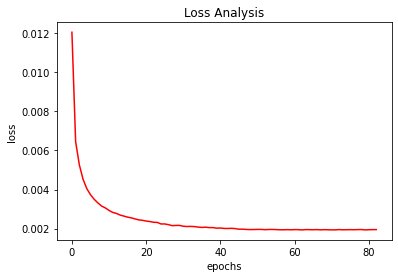

In [53]:
plt.plot(hist.history['loss'], color = 'r')
plt.title('Loss Analysis')
plt.xlabel('epochs')
plt.ylabel('loss')

In [54]:
encoder = Model(inputs = ae_model.input, outputs = ae_model.get_layer('encoding').output, name ='encoder')

In [55]:
x_enc = encoder.predict(x_train)

In [56]:
kmeans = KMeans(n_clusters=10)

In [57]:
labels = kmeans.fit_predict(x_enc)

In [59]:
# get_metrics(x_enc[:10000], labels[:10000])

For n_clusters = 10 The average silhouette_score is : 0.012529336


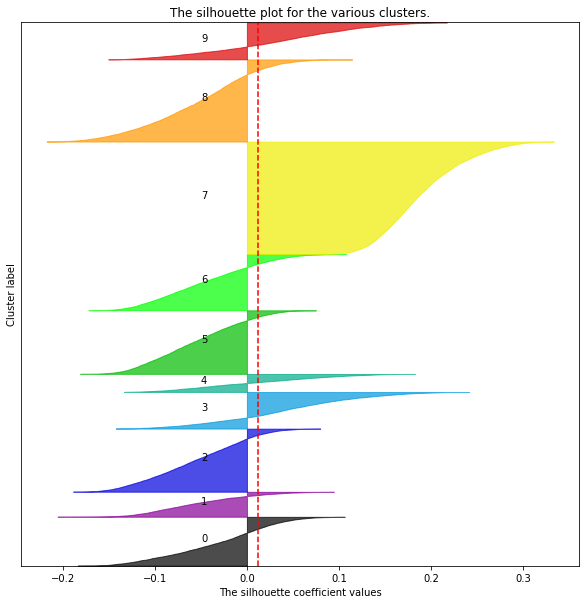

In [60]:
plot_silhoutte_analysis(x_enc, labels, 10)

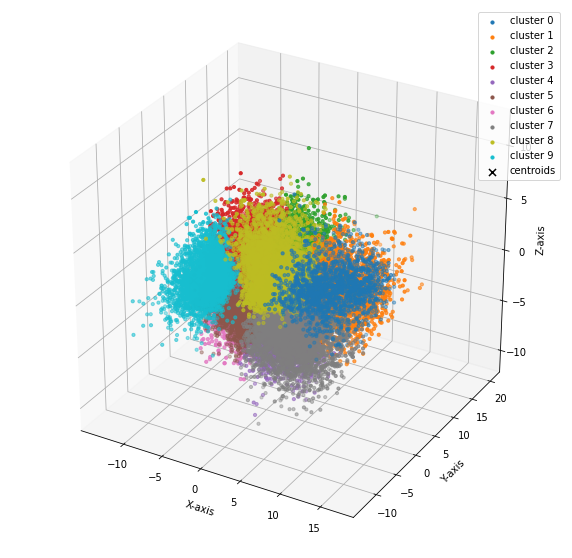

In [51]:
from sklearn.decomposition import PCA

u_labels = np.unique(labels)

pca = PCA(n_components=3)
data_d = pca.fit_transform(x_enc)
cent = pca.fit_transform(kmeans.cluster_centers_)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
for i in u_labels:
    ax.scatter(data_d[labels == i , 0] , data_d[labels == i , 1], data_d[labels == i , 2] , label = 'cluster '+str(i), marker= 'o', s = 10)
ax.scatter(cent[ : , 0] , cent[: , 1], cent[: , 2] , label = 'centroids', marker='x', c = 'black', s = 50)
plt.legend(scatterpoints = 1)
plt.show()